In [1]:
import pandas as pd
import numpy as np
import time
from os.path import basename, dirname, exists
import os
import rasterio
import glob
import ftplib
import urllib2
import zipfile
import gzip
import shutil
from contextlib import closing

In [4]:
%matplotlib inline

In [2]:
#urllib.urlretrieve('ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2017/chirps-v2.0.2017.03.31.tif.gz', 'chirps-v2.0.2017.03.31.tif.gz')
with closing(urllib2.urlopen('ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2017/chirps-v2.0.2017.03.31.tif.gz')) as r:
    with open('chirps-v2.0.2017.03.31.tif.gz', 'wb') as f:
        shutil.copyfileobj(r, f)
!gzip -d chirps-v2.0.2017.03.31.tif.gz
!gdalinfo chirps-v2.0.2017.03.31.tif

gzip: can't open 'chirps-v2.0.2017.03.31.tif': File exists
Driver: GTiff/GeoTIFF
Files: chirps-v2.0.2017.03.31.tif
Size is 7200, 2000
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-180.000000000000000,50.000000000000000)
Pixel Size = (0.050000000745058,-0.050000000745058)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_DATETIME=2017:04:18 15:48:04
  TIFFTAG_DOCUMENTNAME=/home/sandbox/chirps/v2.0/daily_downscaled_by_monthly/global_full_rescale_again/2017/chirps-v2.0.2017.03.31.tif
  TIFFTAG_IMAGEDESCRIPTION=IDL TIFF file
  TIFFTAG_RESOLUTIONUNIT=2 (pixels/inch)
  TIFFTAG_SOFTWARE=IDL 8.5, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
  TIFFTAG_XRESOLUTION=100
  TIFFTAG_YRESOLUTION=100
Image Structure Metadata:
  INTERLEAV

Source:  <open DatasetReader name='./chirps-v2.0.2017.03.31.tif' mode='r'>
Source mode:  r
.TIF Shape:  (2000, 7200)
Source type: ('float32',)
CRS({'init': u'epsg:4326'})
| 0.05, 0.00,-180.00|
| 0.00,-0.05, 50.00|
| 0.00, 0.00, 1.00|


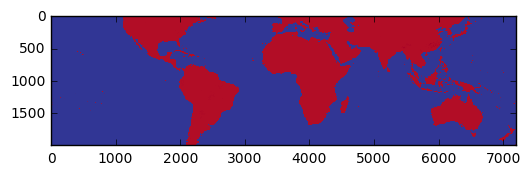

In [5]:
src = rasterio.open('./chirps-v2.0.2017.03.31.tif')
print 'Source: ',src
print 'Source mode: ',src.mode

array = src.read(1)
print '.TIF Shape: ',array.shape

print 'Source type:',src.dtypes
print(src.crs)
print(src.transform)

from matplotlib import pyplot
pyplot.imshow(array, cmap='RdYlBu_r')

pyplot.show()

In [6]:
with rasterio.open('./chirps-v2.0.2017.03.31.tif') as src:
    npixels = src.width * src.height
    for i in src.indexes:
        band = src.read(i)
        print(i, band.min(), band.max(), band.sum()/npixels)

(1, -9999.0, 320.11279, -7318.9137066666663)


In [8]:
CM_IN_FOOT = 30.48


with rasterio.open('./chirps-v2.0.2017.03.31.tif') as src:
    kwargs = src.meta
    kwargs.update(
        driver='GTiff',
        dtype=rasterio.float64,  #rasterio.int16, rasterio.int32, rasterio.uint8,rasterio.uint16, rasterio.uint32, rasterio.float32, rasterio.float64
        count=1,
        compress='lzw',
        nodata=0,
        bigtiff='YES' # Output will be larger than 4GB
    )

    windows = src.block_windows(1)

    with rasterio.open('./chirps-v2.0.2017.03.31.tif','w',**kwargs) as dst:
        for idx, window in windows:
            src_data = src.read(1, window=window)

            # Source nodata value is a very small negative number
            # Converting in to zero for the output raster
            np.putmask(src_data, src_data < 0, 0)

            dst_data = (src_data * CM_IN_FOOT).astype(rasterio.float64)
            dst.write_band(1, dst_data, window=window)

Source:  <open DatasetReader name='./chirps-v2.0.2017.03.31.tif' mode='r'>
Source mode:  r
.TIF Shape:  (2000, 7200)
Source type: ('float64',)
CRS({'init': u'epsg:4326'})
| 0.05, 0.00,-180.00|
| 0.00,-0.05, 50.00|
| 0.00, 0.00, 1.00|


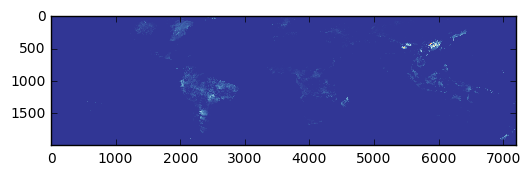

In [9]:
src = rasterio.open('./chirps-v2.0.2017.03.31.tif')
print 'Source: ',src
print 'Source mode: ',src.mode

array = src.read(1)
print '.TIF Shape: ',array.shape

print 'Source type:',src.dtypes
print(src.crs)
print(src.transform)

from matplotlib import pyplot
pyplot.imshow(array, cmap='RdYlBu_r')

pyplot.show()

In [10]:
!gdalinfo chirps-v2.0.2017.03.31.tif

Driver: GTiff/GeoTIFF
Files: chirps-v2.0.2017.03.31.tif
Size is 7200, 2000
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-180.000000000000000,50.000000000000000)
Pixel Size = (0.050000000745058,-0.050000000745058)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-180.0000000,  50.0000000) (180d 0' 0.00"W, 50d 0' 0.00"N)
Lower Left  (-180.0000000, -50.0000015) (180d 0' 0.00"W, 50d 0' 0.01"S)
Upper Right ( 180.0000054,  50.0000000) (180d 0' 0.02"E, 50d 0' 0.00"N)
Lower Right ( 180.0000054, -50.0000015) (180d 0' 0.02"E, 50d 0' 0.01"S)
Center      (   0.0000027,  -0.0000007) (  0d 0' 0.01"E,  0d 0' 0.00"S)
Band 1 Block=7200x1 Type=Float64, ColorInterp=Gray
  NoData Value=0


In [11]:
listing = []
response = urllib2.urlopen('ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2017/')
for line in response:
    print line.rstrip()
    listing.append(line.rstrip())

myarray = np.asarray(listing)

last_file = myarray[[-1]]

-rw-rw-r--    1 31094    31111     3034696 Feb 16 23:53 chirps-v2.0.2017.01.01.tif.gz
-rw-rw-r--    1 31094    31111     3351212 Feb 16 23:53 chirps-v2.0.2017.01.02.tif.gz
-rw-rw-r--    1 31094    31111     3349004 Feb 16 23:53 chirps-v2.0.2017.01.03.tif.gz
-rw-rw-r--    1 31094    31111     3235487 Feb 16 23:53 chirps-v2.0.2017.01.04.tif.gz
-rw-rw-r--    1 31094    31111     3371532 Feb 16 23:53 chirps-v2.0.2017.01.05.tif.gz
-rw-rw-r--    1 31094    31111     3179235 Feb 16 23:53 chirps-v2.0.2017.01.06.tif.gz
-rw-rw-r--    1 31094    31111     3121778 Feb 16 23:53 chirps-v2.0.2017.01.07.tif.gz
-rw-rw-r--    1 31094    31111     3502673 Feb 16 23:53 chirps-v2.0.2017.01.08.tif.gz
-rw-rw-r--    1 31094    31111     3777307 Feb 16 23:53 chirps-v2.0.2017.01.09.tif.gz
-rw-rw-r--    1 31094    31111     4186426 Feb 16 23:53 chirps-v2.0.2017.01.10.tif.gz
-rw-rw-r--    1 31094    31111     3964250 Feb 16 23:53 chirps-v2.0.2017.01.11.tif.gz
-rw-rw-r--    1 31094    31111     3672767 Feb 16 23:5

In [12]:
print last_file

[ '-rw-rw-r--    1 31094    31111     3690161 Apr 18 22:48 chirps-v2.0.2017.03.31.tif.gz']
